In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import math
import seaborn as sns
from sklearn import preprocessing
import networkx as nx

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/pf-test/tracks/A3.tracks.full.csv"

df = pd.read_csv(fpath)
print(f"{df.shape=}")
print()
print(df.columns)
print()
df.head()


df.shape=(374478, 43)

Index(['ID', 't', 'x', 'y', 'z', 'parent', 'root', 'state', 'generation',
       'dummy', 'area_x', 'area_y', 'area_convex', 'area_filled',
       'axis_major_length', 'axis_minor_length', 'eccentricity',
       'c0_intensity_max', 'c1_intensity_max', 'c2_intensity_max',
       'c0_intensity_min', 'c1_intensity_min', 'c2_intensity_min',
       'c0_intensity_mean', 'c1_intensity_mean', 'c2_intensity_mean', 'label',
       'orientation', 'perimeter', 'solidity', 'circularity',
       'c0_logFoldChange_masked', 'c0_logFoldChange_total',
       'c1_logFoldChange_masked', 'c1_logFoldChange_total',
       'c2_logFoldChange_masked', 'c2_logFoldChange_total', 'c0_pval_masked',
       'c0_pval_total', 'c1_pval_masked', 'c1_pval_total', 'c2_pval_masked',
       'c2_pval_total'],
      dtype='object')



,ID,t,x,y,z,parent,root,state,generation,dummy,...,c1_logFoldChange_masked,c1_logFoldChange_total,c2_logFoldChange_masked,c2_logFoldChange_total,c0_pval_masked,c0_pval_total,c1_pval_masked,c1_pval_total,c2_pval_masked,c2_pval_total
0,517,0,452.426471,883.588235,0.0,517,517,5,0,False,...,0.013280,0.013582,0.032024,0.032396,1.000000e+00,1.000000e+00,3.379705e-06,2.198609e-06,5.150800e-09,3.732520e-09
1,156,0,1416.934132,693.526946,0.0,156,156,5,0,False,...,-0.006300,-0.005998,0.025002,0.025373,2.898065e-02,2.383452e-02,1.000000e+00,1.000000e+00,7.410469e-17,3.084331e-17
2,26,0,68.000000,760.000000,0.0,26,26,5,0,False,...,0.013448,0.013750,0.109289,0.109660,1.000000e+00,1.000000e+00,1.631737e-05,1.144253e-05,1.442181e-13,1.283389e-13
3,563,0,495.857143,850.357143,0.0,563,563,5,0,False,...,-0.000364,-0.000062,0.036887,0.037258,4.602903e-09,3.759824e-09,5.897328e-01,5.154645e-01,2.349703e-09,1.759744e-09
4,910,0,287.260274,153.520548,0.0,910,910,5,0,False,...,0.012455,0.012757,0.162051,0.162422,1.000000e+00,1.000000e+00,8.622106e-07,5.186814e-07,2.519632e-24,2.214440e-24


Minutes per Frame: 20
Max Time: 32hrs (96 frames)
Min Track: 18hrs (54 frames)
Random Track Id: 315


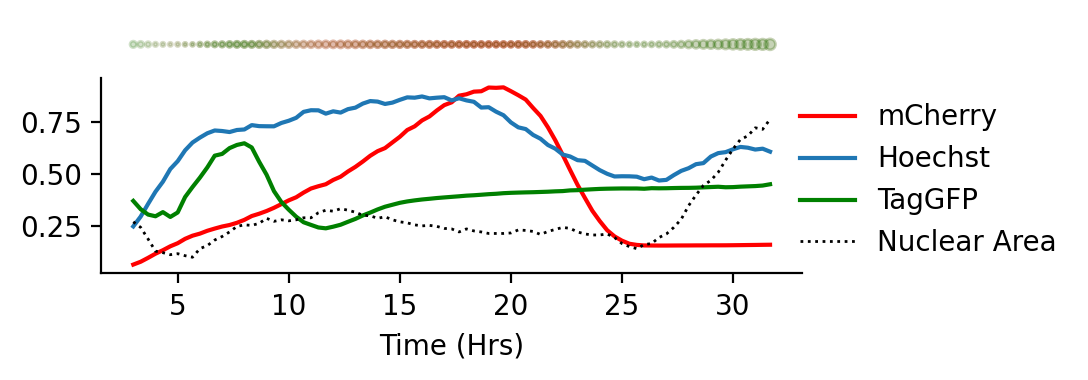

In [17]:
smooth = 10 # in frames
minsPerFrame = 20
maxTime = 32 # in hours
timeFilter = (maxTime *  60) / minsPerFrame # first 72 timepoints == 24 hours
minTrack = 18 # in hours
trackFilter = (minTrack *  60) / minsPerFrame

print(f"Minutes per Frame: {minsPerFrame}")
print(f"Max Time: {maxTime}hrs ({int(timeFilter)} frames)")
print(f"Min Track: {minTrack}hrs ({int(trackFilter)} frames)")

# filter the data
pdf = df.copy()
pdf = pdf[pdf['t'] < timeFilter]
pdf['trackLength'] = pdf.groupby('ID')['x'].count()

longTracks = pdf[pdf['trackLength'] > trackFilter]
rid = np.random.choice(longTracks.index, 1)[0]
# rid = 195
print(f"Random Track Id: {rid}")


# get the track
pdf = pdf[pdf['ID'] == rid].reset_index(drop=True)
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60

c1 = 'c0_logFoldChange_masked'
c2 = 'c1_logFoldChange_masked'
c3 = 'c2_logFoldChange_masked'

min_max_scaler = preprocessing.MinMaxScaler()

# normalize
pdf['c1'] = min_max_scaler.fit_transform(pdf[c1].to_numpy().reshape(-1, 1))
pdf['c2'] = min_max_scaler.fit_transform(pdf[c2].to_numpy().reshape(-1, 1))
pdf['c3'] = min_max_scaler.fit_transform(pdf[c3].to_numpy().reshape(-1, 1))
pdf['A'] = min_max_scaler.fit_transform(pdf['area_convex'].to_numpy().reshape(-1, 1))

# smooth
pdf['c1'] = pdf['c1'].rolling(smooth).mean()
pdf['c2'] = pdf['c2'].rolling(smooth).mean()
pdf['c3'] = pdf['c3'].rolling(smooth).mean()

pdf['A'] = pdf['A'].rolling(smooth).mean()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

fig, ax = plt.subplots()

ax.plot(pdf['Time'], pdf['c1'], c='r', lw=1.5,label='mCherry')
ax.plot(pdf['Time'], pdf['c2'], c='C0', lw=1.5,label='Hoechst')
ax.plot(pdf['Time'], pdf['c3'], c='g', lw=1.5,label='TagGFP')
ax.plot(pdf['Time'], pdf['A'], c='k', lw=1, ls=":", label='Nuclear Area')

plt.legend()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4,1))
ax.set_ylabel("")
ax.set_xlabel("Time (Hrs)")

sns.despine(ax=ax)


ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", 
                             size="25%", 
                             pad=f"5%")

ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='r', alpha=pdf['c1'].fillna(0)*0.5)
ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='g', alpha=pdf['c3'].fillna(0)*0.5)


ax2.set_yticks([])
ax2.set_xticks([])
# ax2.sharex(ax)
sns.despine(ax=ax2, bottom=True, left=True)
plt.tight_layout()

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
df.columns

In [ ]:
smooth = 10 # in frames
minsPerFrame = 20
maxTime = 32 # in hours
timeFilter = (maxTime *  60) / minsPerFrame # first 72 timepoints == 24 hours
minTrack = 18 # in hours
trackFilter = (minTrack *  60) / minsPerFrame

print(f"Minutes per Frame: {minsPerFrame}")
print(f"Max Time: {maxTime}hrs ({int(timeFilter)} frames)")
print(f"Min Track: {minTrack}hrs ({int(trackFilter)} frames)")

# filter the data
pdf = df.copy()
pdf = pdf[pdf['t'] < timeFilter]
pdf['trackLength'] = pdf.groupby('ID')['x'].count()

longTracks = pdf[pdf['trackLength'] > trackFilter]
rid = np.random.choice(longTracks.index, 1)[0]
# rid = 195
print(f"Random Track Id: {rid}")


# get the track
pdf = pdf[pdf['ID'] == rid].reset_index(drop=True)
pdf['Time'] = (pdf['t'] * minsPerFrame) / 60

c1 = 'c0_logFoldChange_masked'
c2 = 'c1_logFoldChange_masked'
c3 = 'c2_logFoldChange_masked'

min_max_scaler = preprocessing.MinMaxScaler()

# normalize
pdf['c1'] = min_max_scaler.fit_transform(pdf[c1].to_numpy().reshape(-1, 1))
pdf['c2'] = min_max_scaler.fit_transform(pdf[c2].to_numpy().reshape(-1, 1))
pdf['c3'] = min_max_scaler.fit_transform(pdf[c3].to_numpy().reshape(-1, 1))
pdf['A'] = min_max_scaler.fit_transform(pdf['area_convex'].to_numpy().reshape(-1, 1))

# smooth
pdf['c1'] = pdf['c1'].rolling(smooth).mean()
pdf['c2'] = pdf['c2'].rolling(smooth).mean()
pdf['c3'] = pdf['c3'].rolling(smooth).mean()

pdf['A'] = pdf['A'].rolling(smooth).mean()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

fig, ax = plt.subplots()

ax.plot(pdf['Time'], pdf['c1'], c='r', lw=1.5,label='mCherry')
ax.plot(pdf['Time'], pdf['c2'], c='C0', lw=1.5,label='Hoechst')
ax.plot(pdf['Time'], pdf['c3'], c='g', lw=1.5,label='mVenus')
ax.plot(pdf['Time'], pdf['A'], c='k', lw=1, ls=":", label='Nuclear Area')

plt.legend()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4,1))
ax.set_ylabel("")
ax.set_xlabel("Time (Hrs)")

sns.despine(ax=ax)


ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", 
                             size="25%", 
                             pad=f"5%")

ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='r', alpha=pdf['c1'].fillna(0)*0.5)
ax2.scatter(pdf['Time'], [1]*len(pdf), s=pdf['A']*20, c='g', alpha=pdf['c3'].fillna(0)*0.5)


ax2.set_yticks([])
ax2.set_xticks([])
# ax2.sharex(ax)
sns.despine(ax=ax2, bottom=True, left=True)
plt.tight_layout()

In [ ]:
break

In [ ]:
pdf.columns

In [ ]:
24 * 3

In [ ]:
minT = 50
minsPerFrame = 20

field1 = 'c0_logFoldChange_total'
field2 = 'c2_logFoldChange_total'

trackLen = df.groupby('ID')['x'].count()
longTracks = trackLen[trackLen > minT]

# 
rid = np.random.choice(longTracks.index, 1)[0]
print(f"{rid=}")
pdf = df[df['ID'] == rid].reset_index(drop=True)

pdf['Time'] = (pdf['t'] * 20) / 60


min_max_scaler = preprocessing.MinMaxScaler()

# normalize
pdf['f1'] = min_max_scaler.fit_transform(pdf[field1].to_numpy().reshape(-1, 1))
pdf['f2'] = min_max_scaler.fit_transform(pdf[field2].to_numpy().reshape(-1, 1))

# smooth
pdf['f1'] = pdf['f1'].rolling(6).mean()
pdf['f2'] = pdf['f2'].rolling(6).mean()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

sns.lineplot(data=pdf, 
             x='Time',
             y='f1',
             lw=1,
             c='r')

sns.lineplot(data=pdf, 
             x='Time',
             y='f2',
             lw=1,
             c='g')

plt.xlabel('Time (hr)')
plt.ylabel('Intensity')
sns.despine()

